# HI Maps Convolution
Author: Raphael Pereira Rolim e Silva

> In this notebook, I attempt to reproduce a HI map Convolution with the help of Alessandro Marins.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys
##############################
from cmcrameri import cm
###############################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data as hdata
import beam_modelling as model

In [2]:
# Get map
path_HI = "/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI256/"
filename = 'HI_I_256_980mhz1260mhz_30bins_full_L0001.fits'
HI = hdata.getmap(dirpath_=path_HI, filename_=filename, healpix_readingformat=False, hdu=1)

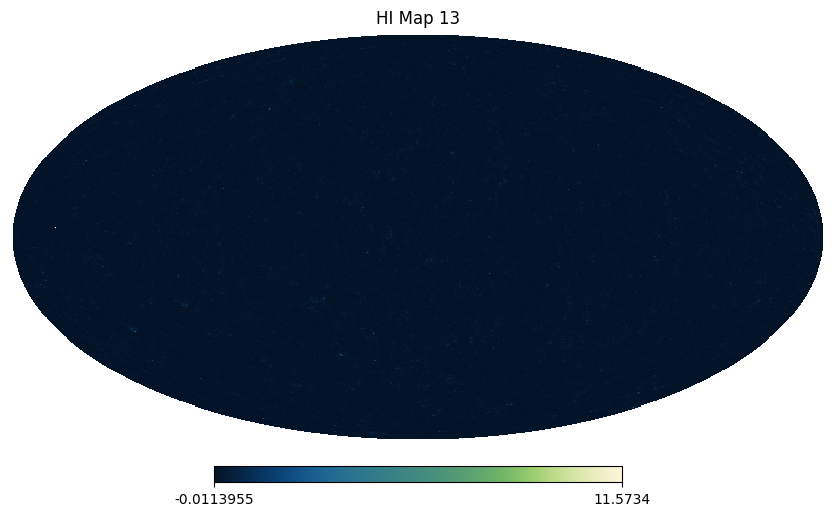

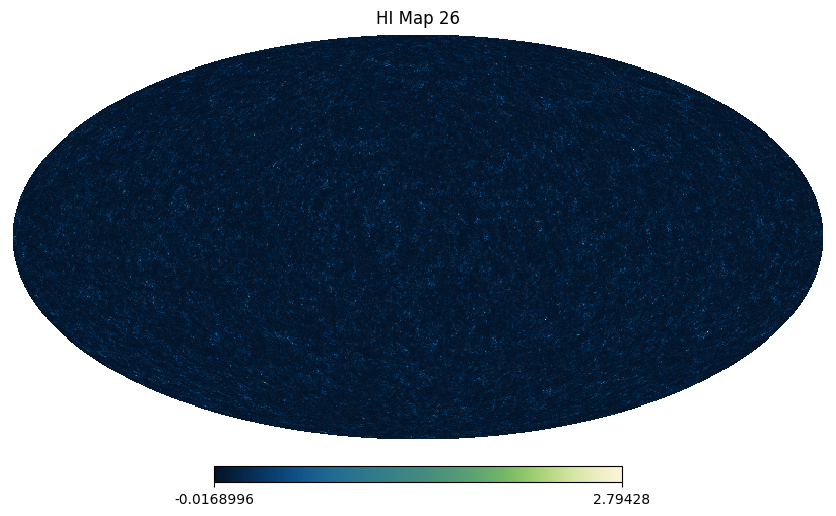

In [3]:
# Visualize
i1 = np.random.randint(0,30)
hp.mollview(HI[i1], cmap=cm.navia, title=f'HI Map {i1}')

i2 = np.random.randint(0,30)
hp.mollview(HI[i2], cmap=cm.navia, title=f'HI Map {i2}')

## Full Width at Half Maximum (FHWM - $\Delta\theta_r$)

Now we need to start our calculations. Accordingly to Matshawule et al (2021), the FWHM ($\Delta\theta_r$) is given by
$$
\Delta\theta_r = \frac{\lambda}{D}\left( \sum_{n=0}^8 a_n \nu^n + A\sin\left(\frac{2\pi\nu}{T}\right) \right),
$$
where $\lambda$ is the observed wavelength and $D$ is the dish diameter, $a_n$ are the 8th order polynomial coefficients, $\nu^n$ are the frequencies of observation (here, distributed in bands of 30), $A$ is the amplitude in arcmin and $T$ is the period in MHz.

The first part of the equation represent the smoothing and when added the second one, a ripple. Here, we are only going to use the smoothing.

In [4]:
# Adjusting nu
nbands = 30 # 30 bands of frequency
nu_min = 980 # min frequency of observation
nu_max = 1260 # max frequency of observation
nu_step = (nu_max-nu_min)/nbands
nu = np.around(np.arange(nu_min,nu_max,nu_step),decimals=2) # our list of frequencies (nu^n)

In [5]:
# Adjusting ell
nside = hp.get_nside(HI[0])
lmax = 3*nside
l = np.arange(lmax+1) # list of ells from 0 to 3*nside (768)

In [6]:
# FWHM (Delta theta_r)
fwhm  = model.fwhm_modelling(nu=nu[0],type_='smooth', D=40, in_degree=True)

Where $D=40$ m is for BINGO radio-telescope.

## Beam Convolution

To simulate the sky brightness, we need to convolve the sky map. Here we are going to use a Gaussian Beam. The brightness temperature can be obtained by
$$
\tilde{T}_\text{sky}(\nu,\theta,\phi) = \int [\hat{R}(\theta,\phi)B](\nu,\theta',\phi')T_\text{sky}(\nu,\theta',\phi') \ \text{d}\Omega',
$$
where $\theta$ is the polar angle, $\phi$ is the azimutal angle, $\text{d}\Omega' = \sin\theta'\text{d}\theta'\text{d}\phi'$ is the solid angle, $\hat{R}$ is the operator of finite rotations such that $\hat{R}B$ is the rotated beam into the $(\theta,\phi)$ direction.

It's easier to compute if we move to spherical harmonics space,
$$
T(\nu,\theta,\phi) = \sum_{\ell=0}^{\ell_\text{max}} \sum_{m=-\ell}^{\ell} a_{\ell m}(\nu) Y_{\ell m}(\theta, \phi),
$$
where $Y_{\ell m}(\theta, \phi)$ are the spherical harmonic functions and $a_{\ell m}(\nu)$ are the spherical harmonic coefficients,
$$
a_{\ell m}(\nu) = \int T(\nu,\theta,\phi) Y^*_{\ell m}(\theta,\phi) \ \text{d} \Omega.
$$

For a symmetrical beam, we have
$$
B(\nu,\theta) = \sum_\ell b_\ell(\nu)Y_{\ell 0}(\theta,\phi),
$$
where the beam harmonics coefficients $b_\ell$ do not depend on $m$ and can be written as
$$
b_\ell(\nu) = \int B(\nu,\theta,\phi) Y^*_{\ell 0}(\theta,\phi) \ \text{d}\Omega.
$$

This computation is made by `hp.beam2bl`. For a Gaussian Beam, the real space beam profile $b_\ell(\theta)$ can be obtained by
$$
b_\ell(\theta) = \exp\left( -4 \cdot \log(2) \cdot \frac{\theta^2}{\Delta\theta_r^2} \right),
$$
and then normalized.

In [7]:
# Adjusting theta
theta = np.arange(0,10,0.01)

In [8]:
# Get gaussian beam
blg = model.bl_function(type_='gaussian', fwhm=fwhm, lmax=lmax, theta_=theta, input_unit='degree')

In [9]:
# Get Cl
cl = hp.anafast(HI[0], lmax=lmax, pol=False)

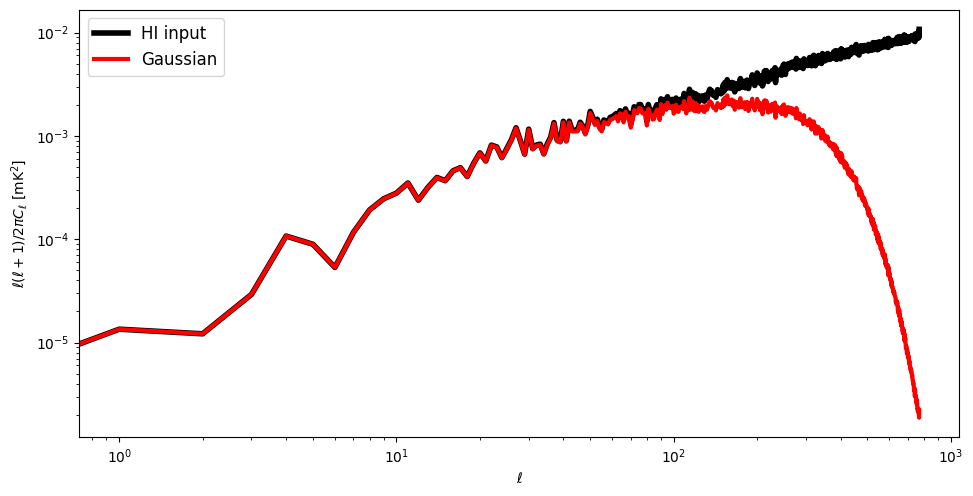

In [10]:
# Plot beam by ell
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
factor = l*(l+1)/(2*np.pi)
plt.plot(l, factor*cl, label='HI input', linewidth=4, color='black')
plt.plot(l, factor*cl*(blg**2), label='Gaussian', linewidth=3, color='red')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)/2\pi C_\ell$ [mK$^2$]')
plt.legend(fontsize='large');

We can see here that for a higher $\ell$ (smaller angle of vision), our gaussian beam $C_\ell$ goes to 0 because there isn't a resolution in this level of observation. Let's see the result:

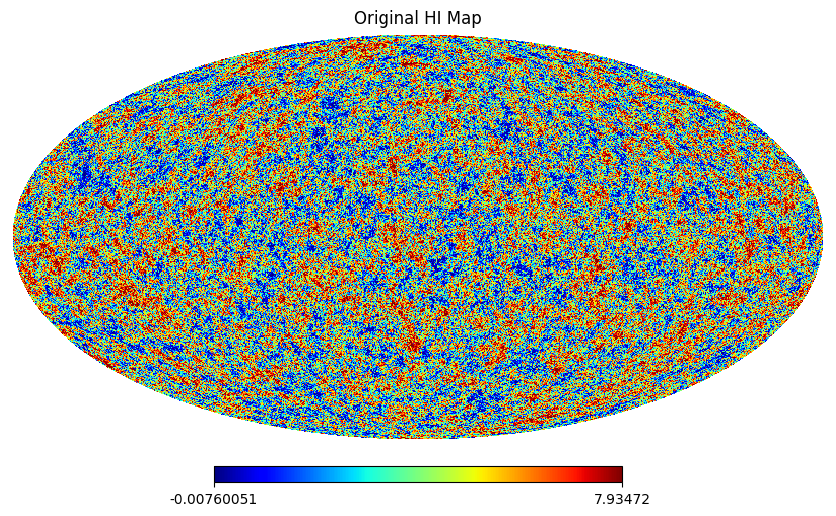

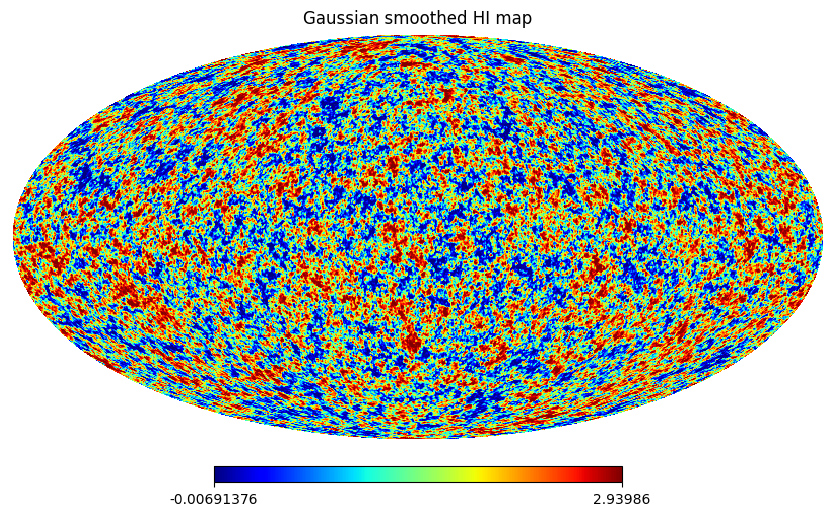

In [11]:
# Visualize results
g_smoothed_map = hp.smoothing(HI[0], beam_window=blg)
hp.mollview(HI[0], cmap='jet', norm='hist', title='Original HI Map')
hp.mollview(g_smoothed_map, cmap='jet', norm='hist', title='Gaussian smoothed HI map')

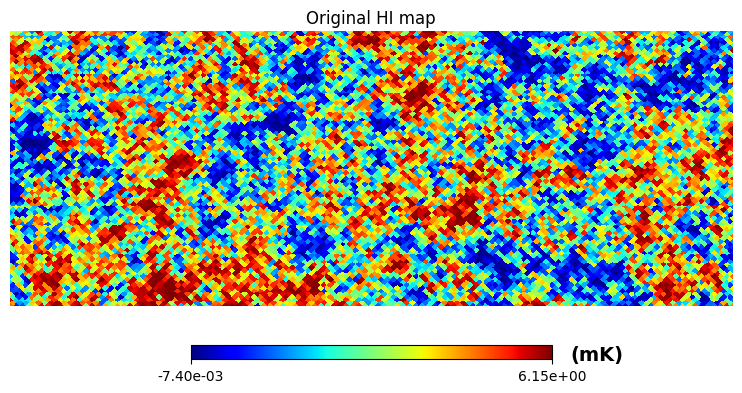

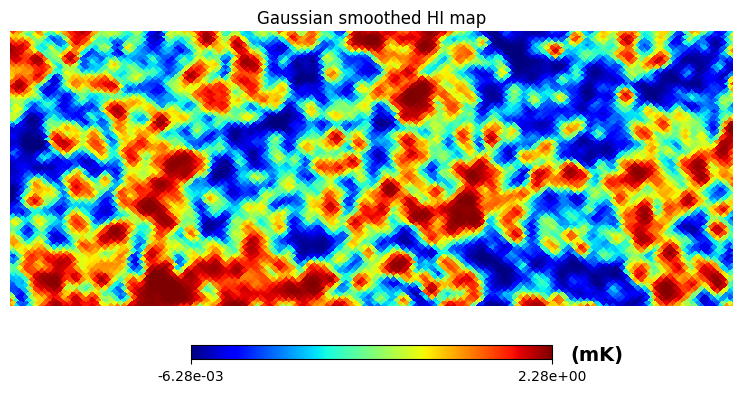

In [12]:
# Cartview
Dec_min = -25 - 0.1
Dec_max = -10 + 0.1
Ra_min  = -20
Ra_max  = 20
CMAP    = "jet"
hp.cartview(HI[0], norm="hist", latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap='jet', format='%.2e', unit=r'(mK)', title='Original HI map')
hp.cartview(g_smoothed_map, norm="hist", latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap='jet', format='%.2e', unit=r'(mK)', title='Gaussian smoothed HI map')

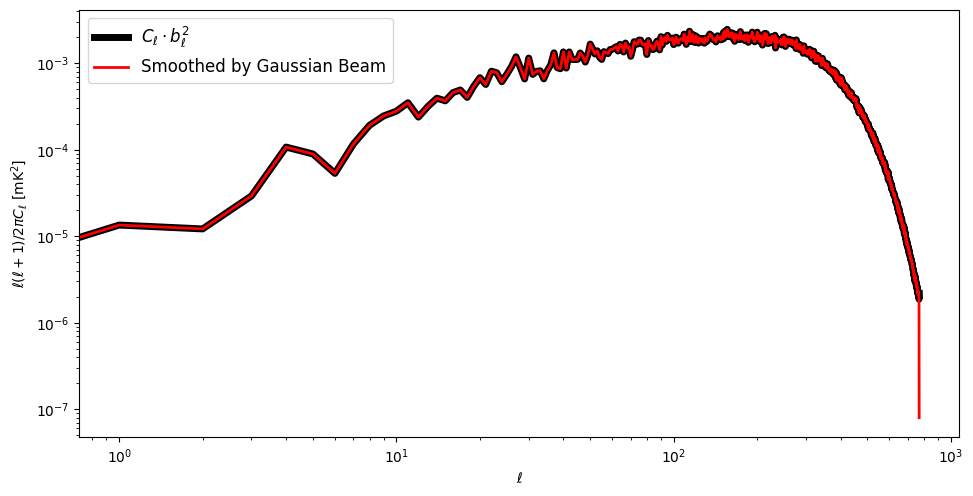

In [13]:
# Plot Cls to check if it's correct
g_smoothed_cl = hp.anafast(g_smoothed_map, lmax=lmax, pol=False)

grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
factor = l*(l+1)/(2*np.pi)
plt.plot(l, factor*cl*(blg**2), label=r'$C_\ell \cdot b_\ell^2$', linewidth=5, color='black')
plt.plot(l, factor*g_smoothed_cl, label='Smoothed by Gaussian Beam', linewidth=2, color='red')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)/2\pi C_\ell$ [mK$^2$]')
plt.legend(fontsize='large');

## Cosine Beam Model

In [14]:
# Cosine beam model
blc = model.bl_function(type_='cosine', fwhm=fwhm, lmax=lmax, theta_=theta, input_unit='degree')

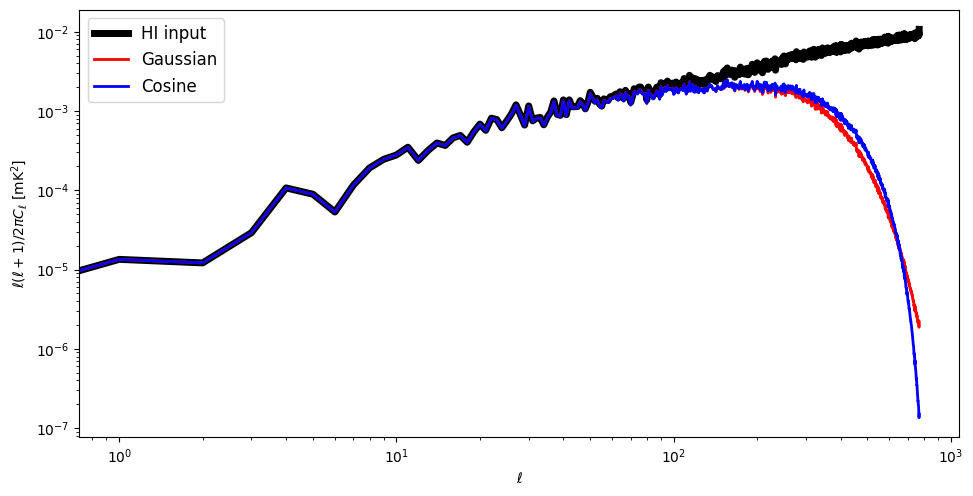

In [15]:
# Plot beam by ell
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
factor = l*(l+1)/(2*np.pi)
plt.plot(l, factor*cl, label='HI input', linewidth=5, color='black')
plt.plot(l, factor*cl*(blg**2), label='Gaussian', linewidth=2, color='red')
plt.plot(l, factor*cl*(blc**2), label='Cosine', linewidth=2, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)/2\pi C_\ell$ [mK$^2$]')
plt.legend(fontsize='large');

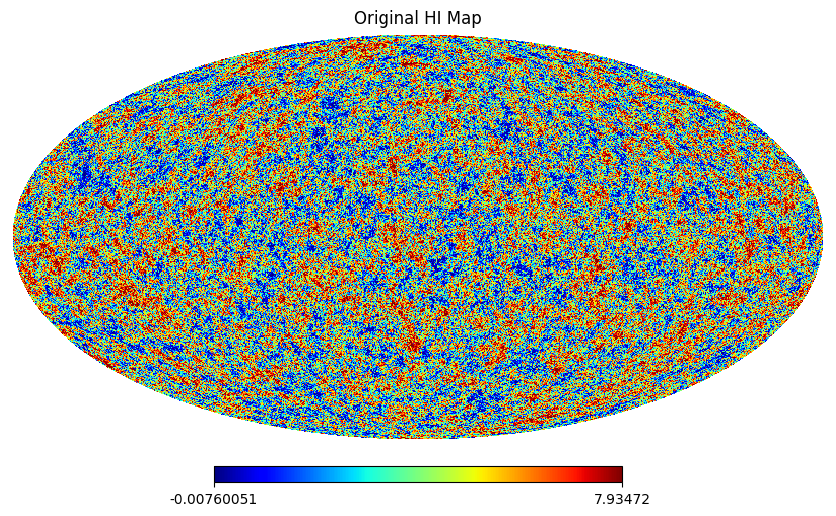

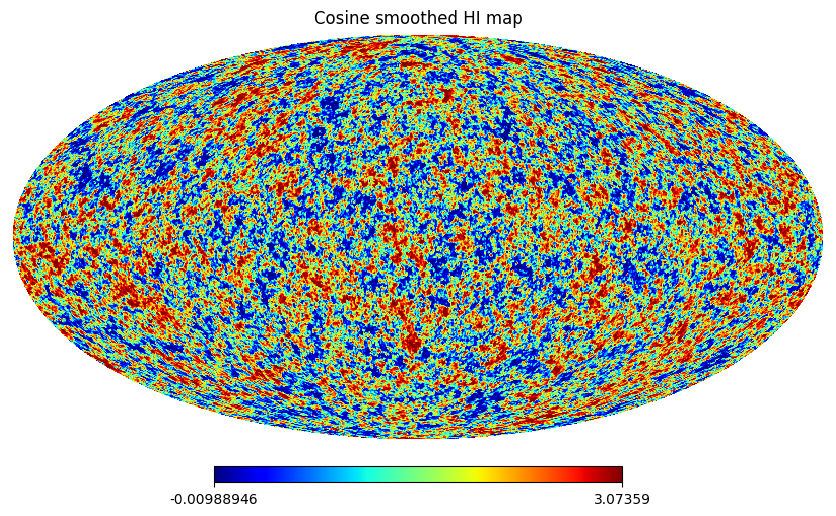

In [16]:
# Visualize results
c_smoothed_map = hp.smoothing(HI[0], beam_window=blc)
hp.mollview(HI[0], cmap='jet', norm='hist', title='Original HI Map')
hp.mollview(c_smoothed_map, cmap='jet', norm='hist', title='Cosine smoothed HI map')

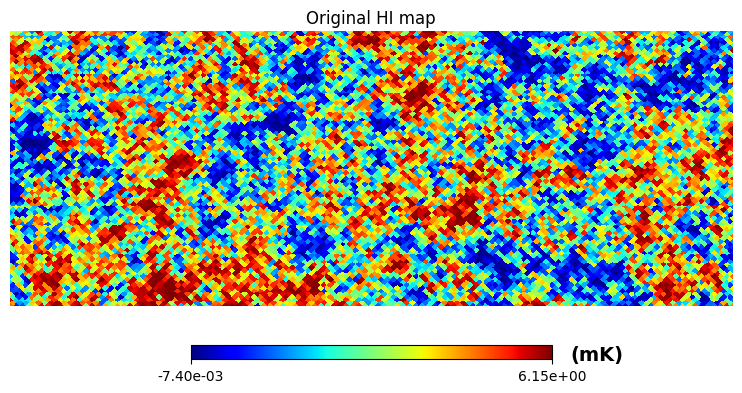

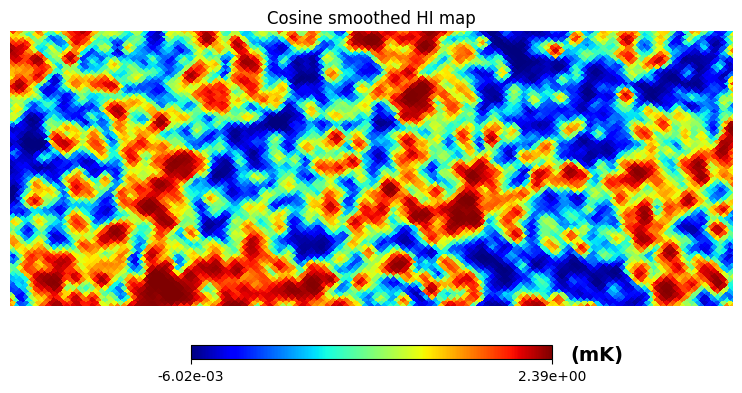

In [17]:
# Cartview
Dec_min = -25 - 0.1
Dec_max = -10 + 0.1
Ra_min  = -20
Ra_max  = 20
hp.cartview(HI[0], norm="hist", latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap='jet', format='%.2e', unit=r'(mK)', title='Original HI map')
hp.cartview(c_smoothed_map, norm="hist", latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap='jet', format='%.2e', unit=r'(mK)', title='Cosine smoothed HI map')

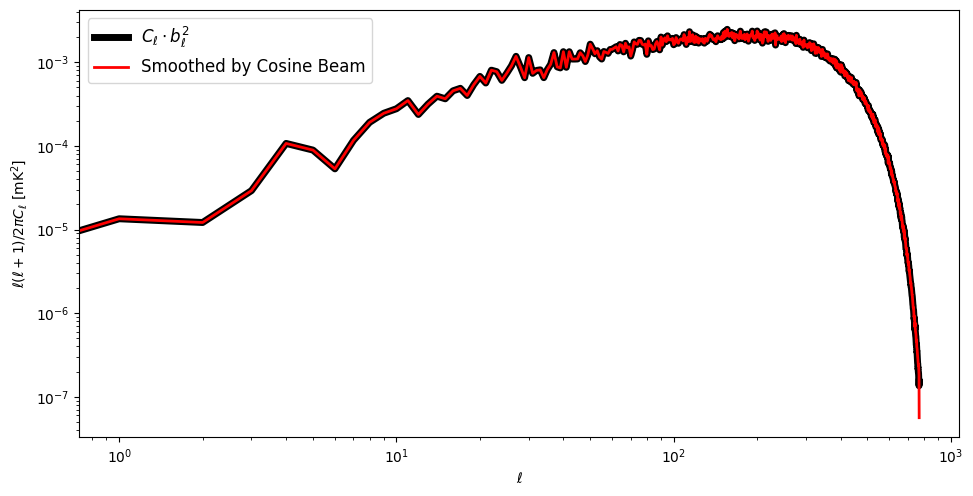

In [18]:
# Plot Cls to check if it's correct
c_smoothed_cl = hp.anafast(c_smoothed_map, lmax=lmax, pol=False)

grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
factor = l*(l+1)/(2*np.pi)
plt.plot(l, factor*cl*(blc**2), label=r'$C_\ell \cdot b_\ell^2$', linewidth=5, color='black')
plt.plot(l, factor*c_smoothed_cl, label='Smoothed by Cosine Beam', linewidth=2, color='red')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)/2\pi C_\ell$ [mK$^2$]')
plt.legend(fontsize='large');

## Jinc Beam Model

In [19]:
# Jinc beam model
blj = model.bl_function(type_='jinc', fwhm=fwhm, lmax=lmax, theta_=theta, input_unit='degree')

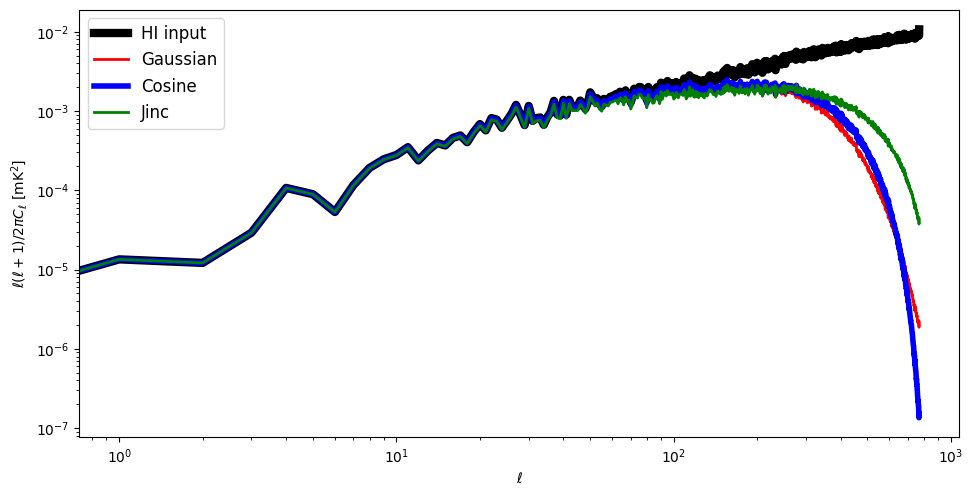

In [20]:
# Plot beam by ell
grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
factor = l*(l+1)/(2*np.pi)
plt.plot(l, factor*cl, label='HI input', linewidth=6, color='black')
plt.plot(l, factor*cl*(blg**2), label='Gaussian', linewidth=2, color='red')
plt.plot(l, factor*cl*(blc**2), label='Cosine', linewidth=4, color='blue')
plt.plot(l, factor*cl*(blj**2), label='Jinc', linewidth=2, color='green')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)/2\pi C_\ell$ [mK$^2$]')
plt.legend(fontsize='large');

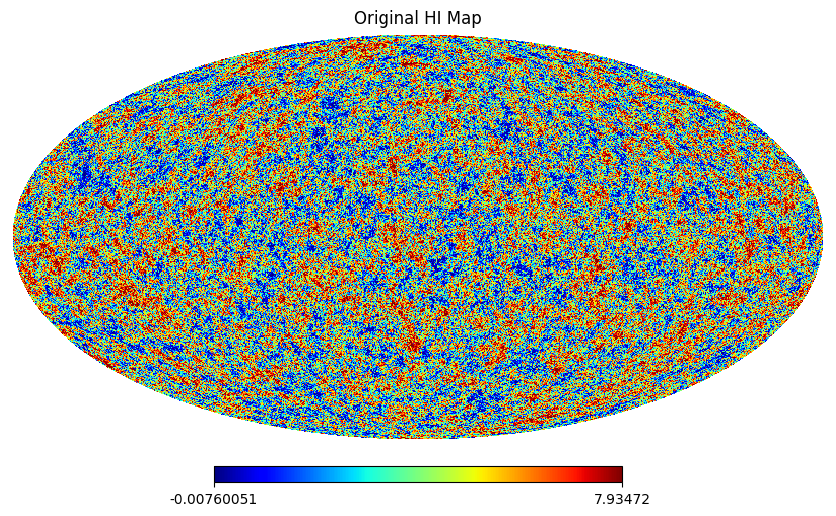

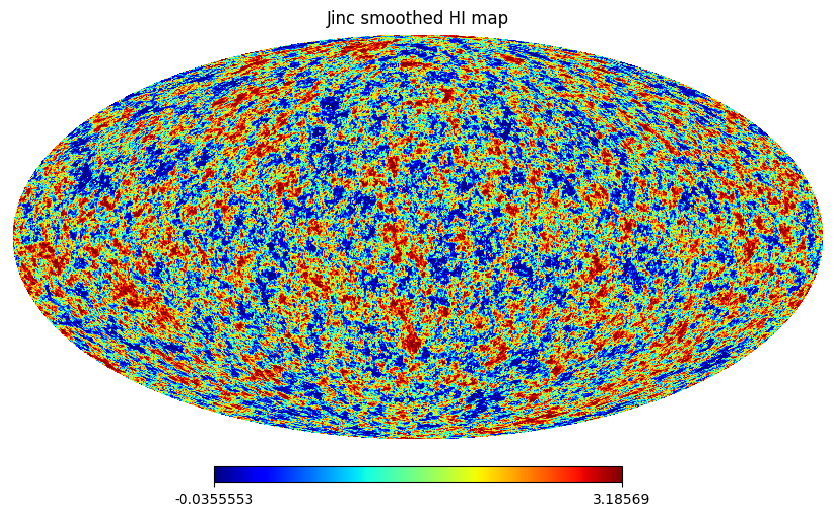

In [21]:
# Visualize results
j_smoothed_map = hp.smoothing(HI[0], beam_window=blj)
hp.mollview(HI[0], cmap='jet', norm='hist', title='Original HI Map')
hp.mollview(j_smoothed_map, cmap='jet', norm='hist', title='Jinc smoothed HI map')

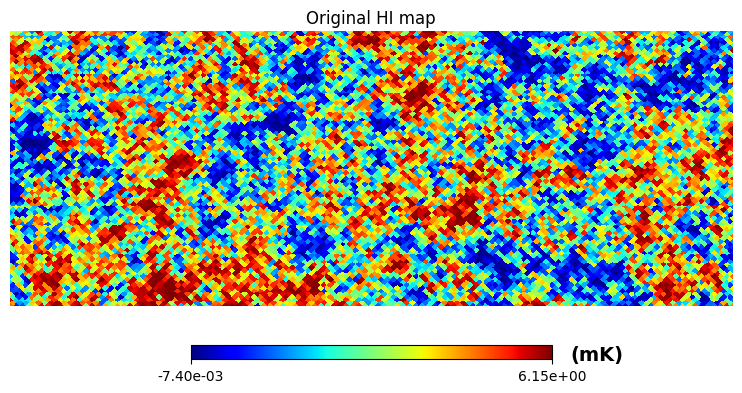

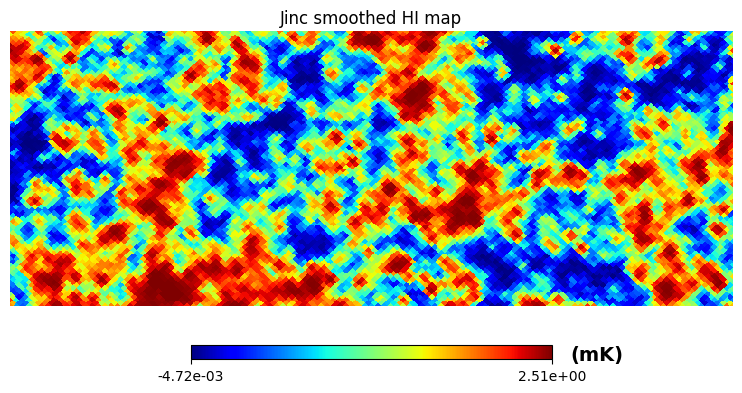

In [22]:
# Cartview
Dec_min = -25 - 0.1
Dec_max = -10 + 0.1
Ra_min  = -20
Ra_max  = 20
hp.cartview(HI[0], norm="hist", latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap='jet', format='%.2e', unit=r'(mK)', title='Original HI map')
hp.cartview(j_smoothed_map, norm="hist", latra=[Dec_min,Dec_max], lonra=[Ra_min,Ra_max], cmap='jet', format='%.2e', unit=r'(mK)', title='Jinc smoothed HI map')

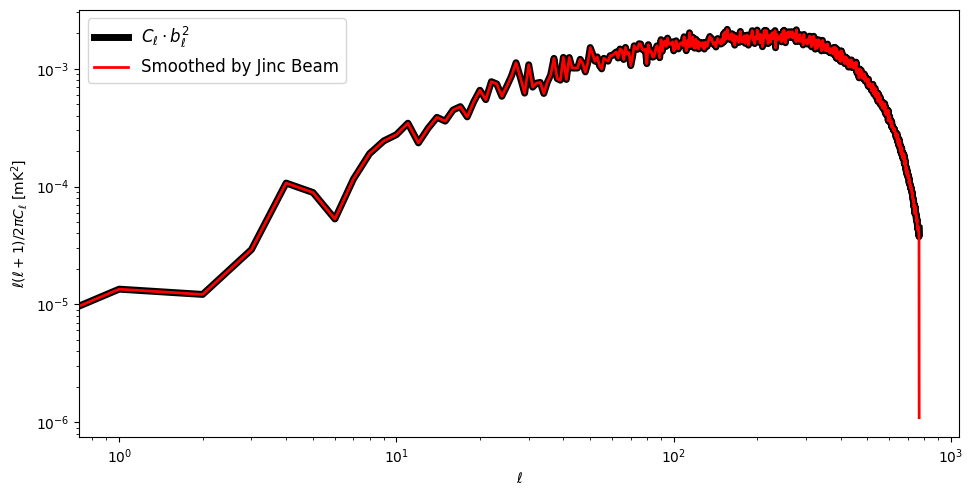

In [23]:
# Plot Cls to check if it's correct
j_smoothed_cl = hp.anafast(j_smoothed_map, lmax=lmax, pol=False)

grid = plt.GridSpec(1,1,top=1.,right=1.5,wspace=0.03)
ax = plt.subplot(grid[0,0])
factor = l*(l+1)/(2*np.pi)
plt.plot(l, factor*cl*(blj**2), label=r'$C_\ell \cdot b_\ell^2$', linewidth=5, color='black')
plt.plot(l, factor*j_smoothed_cl, label='Smoothed by Jinc Beam', linewidth=2, color='red')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)/2\pi C_\ell$ [mK$^2$]')
plt.legend(fontsize='large');

## Plot all to compare

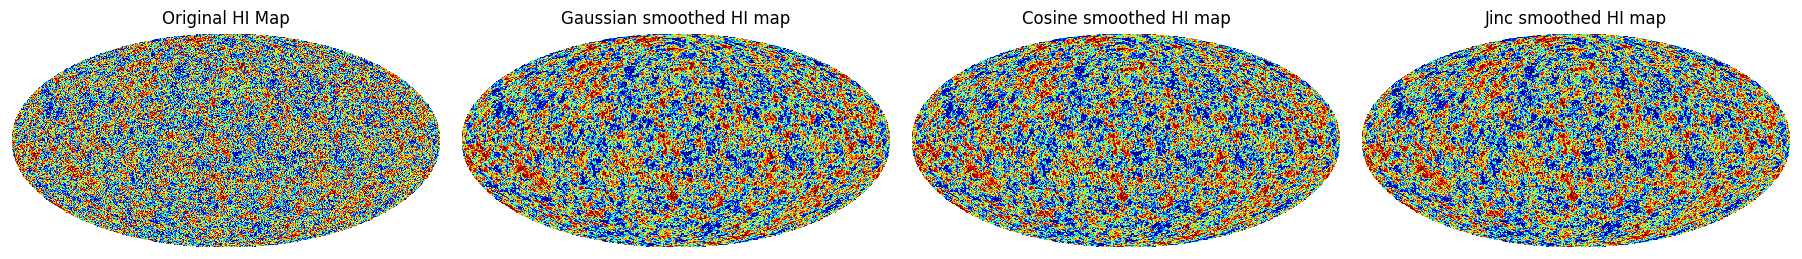

In [43]:
# Mollwide view
fig, axes = plt.subplots(1, 4, figsize=(18, 12),
                         subplot_kw={'projection': 'mollweide'},
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

titles = ['Original HI Map',
          'Gaussian smoothed HI map',
          'Cosine smoothed HI map',
          'Jinc smoothed HI map'   
]

maps = [HI[0], g_smoothed_map, c_smoothed_map, j_smoothed_map]

# Plot each map individually
hp.mollview(maps[0], norm='hist', fig=fig, sub=(1, 4, 1), title=titles[0], cmap='jet', cbar=False)
hp.mollview(maps[1], norm='hist', fig=fig, sub=(1, 4, 2), title=titles[1], cmap='jet', cbar=False)
hp.mollview(maps[2], norm='hist', fig=fig, sub=(1, 4, 3), title=titles[2], cmap='jet', cbar=False)
hp.mollview(maps[3], norm='hist', fig=fig, sub=(1, 4, 4), title=titles[3], cmap='jet', cbar=False)

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('mollweide_maps.png', bbox_inches='tight')

plt.show()

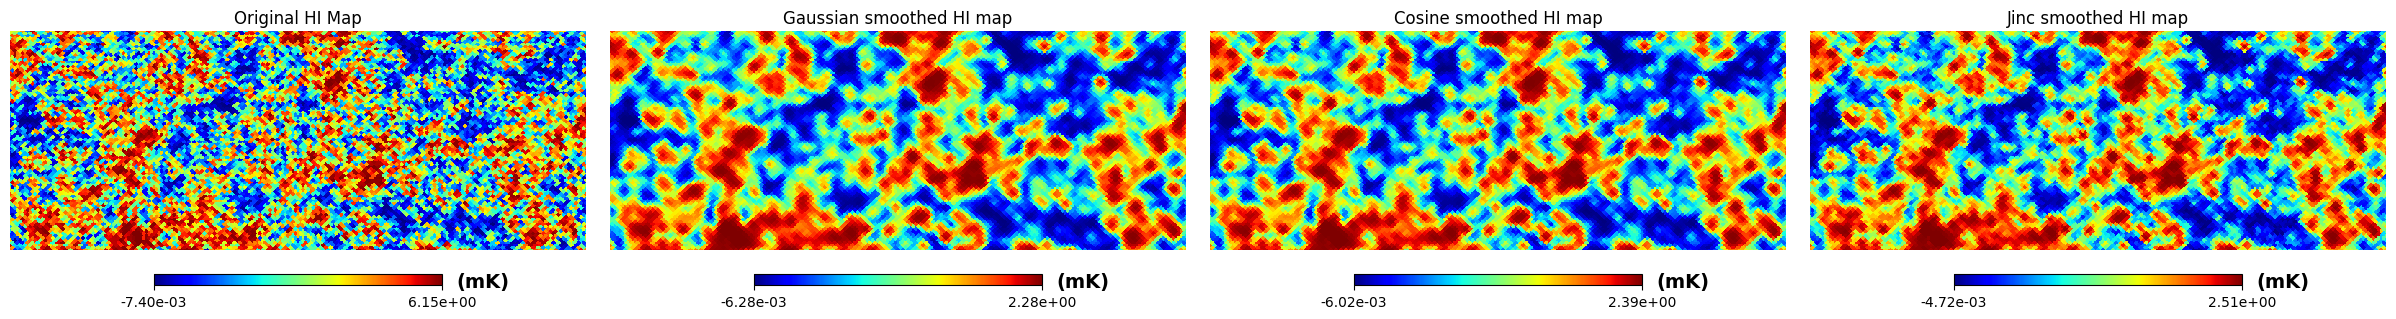

In [44]:
# Cart view
fig, axes = plt.subplots(1, 4, figsize=(24, 3),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

titles = ['Original HI Map',
          'Gaussian smoothed HI map',
          'Cosine smoothed HI map',
          'Jinc smoothed HI map'   
]

maps = [HI[0], g_smoothed_map, c_smoothed_map, j_smoothed_map]

# Plot each map individually
hp.cartview(maps[0], norm="hist", latra=[Dec_min, Dec_max], lonra=[Ra_min, Ra_max], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(maps[1], norm="hist", latra=[Dec_min, Dec_max], lonra=[Ra_min, Ra_max], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[1], fig=fig, sub=(1, 4, 2))
hp.cartview(maps[2], norm="hist", latra=[Dec_min, Dec_max], lonra=[Ra_min, Ra_max], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[2], fig=fig, sub=(1, 4, 3))
hp.cartview(maps[3], norm="hist", latra=[Dec_min, Dec_max], lonra=[Ra_min, Ra_max], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[3], fig=fig, sub=(1, 4, 4))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('cartview_maps.png', bbox_inches='tight')

plt.show()

## Bibliography

1. [Matshawule et al (2021)](https://arxiv.org/pdf/2011.10815)